# Robustness tokens

Recently, [Vision Transformers Need Registers
 by Darcet et al.](https://arxiv.org/abs/2309.16588) and [Efficient Streaming Language Models with Attention Sinks by Xiao et.](https://arxiv.org/abs/2309.17453) have proposed adding additional tokens to the input sequence of transformer models to get rid of artifacts in the attention maps of vision models and to improve performances of language models on large sequences respectively.

This promising trend of adding additional tokens to the transformer architecture that do not represent the input sequence, but that are being used by the transformer to improve its performances, is very interesting.

In this work, we propose robustness tokens. The idea is to use additional tokens (a.k.a registers) to improve the robustness of ViT to adversarial attacks.

In [1]:
import torch
from torch.nn import Module
from torch.optim import Adam
from torch.nn.functional import cosine_similarity, mse_loss

import pytorch_lightning as pl

from PIL import Image
import requests as r
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, ToPILImage

pl.seed_everything(0)

/home/users/p/pulfer/.conda/envs/rtokens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


0

In [2]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

normalize = Normalize(imagenet_mean, imagenet_std)
unnormalize = Normalize(
    [-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    [1/s for s in imagenet_std]
)

to_tensor = ToTensor()
to_pil = ToPILImage()

transform = Compose([
    Resize((224, 224)),
    to_tensor,
    normalize
])

to_img = Compose([
    unnormalize,
    to_pil
])

def get_image_tensor(url):
    image = Image.open(r.get(url, stream=True).raw)
    return transform(image).unsqueeze(0).cuda()

URL_IMG_1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
URL_IMG_2 = "http://images.cocodataset.org/val2017/000000000139.jpg"

In [6]:
SUPPORTED_DINOV2_MODELS = [
    "dinov2_vits14",
    "dinov2_vitb14",
    "dinov2_vitl14",
    "dinov2_vitg14",
]


def get_model(name, enbable_robust=True, return_cls=False, n_rtokens=1):
    if name in SUPPORTED_DINOV2_MODELS:
        return DinoV2Robustifier(
            model_name=name,
            enable_robust=enbable_robust,
            return_cls=return_cls,
            n_rtokens=n_rtokens,
        )
    raise KeyError(f"Model {name} not supported. Pick one of {SUPPORTED_DINOV2_MODELS}")


class DinoV2Robustifier(Module):
    def __init__(self, model_name, enable_robust=False, return_cls=False, n_rtokens=1):
        super(DinoV2Robustifier, self).__init__()

        assert (
            model_name in SUPPORTED_DINOV2_MODELS
        ), f"{model_name} not supported. Pick one of {SUPPORTED_DINOV2_MODELS}"

        self.model_name = model_name
        self.model = torch.hub.load("facebookresearch/dinov2", model_name).eval()
        self.enable_robust = enable_robust
        self.return_cls = return_cls
        self.n_rtokens = max(0, n_rtokens)
        
        if self.n_rtokens > 0:
            hidden_dim = self.model.cls_token.shape[-1]
            self.rtokens = torch.nn.Parameter(1e-2 * torch.randn(1, n_rtokens, hidden_dim))
            # self.rtokens = torch.nn.Parameter(torch.zeros(1, n_rtokens, hidden_dim))
        else:
            self.extra_params = torch.nn.ParameterList([1e-3 * torch.randn_like(p) for p in self.model.parameters()])
            self.added_params = False

    def get_trainable_parameters(self):
        if self.n_rtokens > 0:
            return [self.rtokens]
        return self.extra_params

    def forward(self, x, enable_robust=None, return_cls=None, return_rtokens=False):
        b, c, w, h = x.shape
        running_cls = return_cls if return_cls is not None else self.return_cls
        running_robust = (
            enable_robust if enable_robust is not None else self.enable_robust
        )
        
        if self.n_rtokens == 0:
            if running_robust:
                self.add_extra_params()
            else:
                self.remove_extra_params()

        # Embedding patches
        x = self.model.patch_embed(x)

        # Concatenating class token
        x = torch.cat((self.model.cls_token.expand(b, -1, -1), x), dim=1)
        x += self.model.interpolate_pos_encoding(x, w, h)

        # Appending robust tokens
        if running_robust and self.n_rtokens > 0:
            x = torch.cat((x, self.rtokens.repeat(b, 1, 1)), dim=1)

        # Running blocks
        for blk in self.model.blocks:
            x = blk(x)
        x = self.model.norm(x)

        if running_cls:
            return self.model.head(x[:, 0])

        if not return_rtokens and self.n_rtokens > 0 and running_robust:
            return x[:, : -self.n_rtokens]

        return x
    
    def add_extra_params(self):
        if not self.added_params:
            for p1, p2 in zip(self.extra_params, self.model.parameters()):
                p2.data += p1.data
            self.added_params = True
        
    def remove_extra_params(self):
        if self.added_params:
            for p1, p2 in zip(self.extra_params, self.model.parameters()):
                p2.data -= p1.data
            self.added_params = False



In [7]:
def psnr_to_mse(psnr):
    return 10 ** (-psnr / 10)

def validate(batch):
    imgs = [to_pil(unnormalize(img).clamp(0, 1)) for img in batch]
    imgs = [normalize(to_tensor(img)) for img in imgs]
    batch = torch.stack(imgs).cuda()
    return batch

def pgd_attack(model, batch, steps=350, lr=4e-4, max_mse=1e-4, eps=8/255, verbose=False):
    model.eval()
    with torch.no_grad():
        target = model(batch).detach()
        img_target = unnormalize(batch).detach()

    lower, upper = batch.min(), batch.max()
    batch_adv = (batch + lr * torch.randn_like(batch)).detach().clone()
    batch_adv.requires_grad = True
    for step in range(steps):
        # Minimize cosine similarity an MSE
        pred = model(batch_adv)
        img_pred = unnormalize(batch_adv)

        f_loss = cosine_similarity(pred, target).mean()
        i_loss = mse_loss(img_pred, img_target).mean()
        loss = f_loss + i_loss

        loss.backward()
        batch_adv.data = batch_adv.data - lr * batch_adv.grad.sign()
        batch_adv.grad.zero_()

        # Projection
        if eps is not None:
            batch_adv = batch + torch.clamp(batch_adv - batch, -eps, eps)

        # Stay within range
        batch_adv = torch.clamp(batch_adv, lower, upper).clone().detach()
        batch_adv.requires_grad = True

        # Print progress
        if verbose and ((step + 1) % (steps // 10) == 0 or step == 0):
            print(f"Step {step+1}/{steps}: {loss.item():.3f} (f_loss: {f_loss.item():.3f}, i_loss: {i_loss.item():.3f})")

        # Stop if MSE is too high
        if max_mse is not None:
            if i_loss >= max_mse:
                break

    # Quantizing
    batch_adv = validate(batch_adv)
    return batch_adv.clone().detach()

In [27]:
model_name = "dinov2_vits14"
dinov2 = torch.hub.load('facebookresearch/dinov2', model_name).cuda().eval()
model = DinoV2Robustifier(
    model_name,
    enable_robust=True,
    return_cls=False,
    n_rtokens=0
).cuda().eval()

# Sanity check
x = get_image_tensor(URL_IMG_1)
with torch.no_grad():
    y1 = dinov2(x)
    y2 = model(x, enable_robust=False, return_cls=True)
    y3 = model(x, enable_robust=True, return_cls=True)
    
    assert torch.allclose(y1, y2, atol=1e-6), "Model without robustness tokens should be the same as the original model"
    assert not torch.allclose(y1, y3, atol=1e-6) or model.n_rtokens < 1, "Model with robustness tokens should be different from the original model"
    print("Sanity check passed")
    
    # Checking difference with and without robustness tokens
    # nrf = model(x, enable_robust=False, return_cls=False)
    # rf = model(x, enable_robust=True, return_cls=False, return_rtokens=False)
    # sim = torch.nn.functional.cosine_similarity(nrf, rf).mean().item()
    # print(f"Cosine similarity with and without robustness token: {sim:.3f}")

Using cache found in /home/users/p/pulfer/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/users/p/pulfer/.cache/torch/hub/facebookresearch_dinov2_main


Sanity check passed


Step 1/30: 1.000 (f_loss: 1.000, i_loss: 0.000)
Step 3/30: 0.811 (f_loss: 0.811, i_loss: 0.000)
Step 6/30: 0.267 (f_loss: 0.267, i_loss: 0.000)
Step 9/30: -0.083 (f_loss: -0.083, i_loss: 0.000)
Step 12/30: -0.205 (f_loss: -0.205, i_loss: 0.000)
Step 15/30: -0.220 (f_loss: -0.220, i_loss: 0.000)
Step 18/30: -0.264 (f_loss: -0.264, i_loss: 0.000)
Step 21/30: -0.290 (f_loss: -0.290, i_loss: 0.000)
Step 24/30: -0.308 (f_loss: -0.308, i_loss: 0.000)
Step 27/30: -0.302 (f_loss: -0.302, i_loss: 0.000)
Step 30/30: -0.352 (f_loss: -0.352, i_loss: 0.000)
MSE: 0.00003
Cosine similarity: -0.31


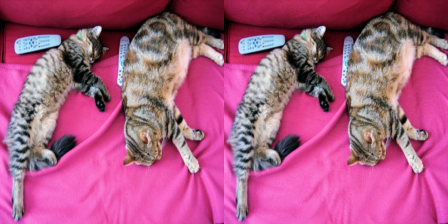

In [30]:
x_adv = pgd_attack(dinov2, x, steps=30, lr=1e-2, eps=8/255, verbose=True)
f1, f2 = dinov2(x), dinov2(x_adv)
imgt, imgtadv = unnormalize(x), unnormalize(x_adv)
print(f"MSE: {((imgt - imgtadv) ** 2).mean():.5f}")
print(f"Cosine similarity: {torch.cosine_similarity(f1, f2).mean():.2f}")

to_pil(torch.cat((imgt, imgtadv), dim=-1)[0])

In [31]:
def train_robustness_token(model, x, x_adv, steps=600, lr=1e-4, verbose=False):
    optim = Adam(model.get_trainable_parameters(), lr=lr, maximize=True)
    
    with torch.no_grad():
        model.enbable_robust = False
        target = model(x).detach().clone()
    
    model.enbable_robust = True
    for step in range(steps):
        l_inv = torch.cosine_similarity(model(x), target).mean()
        l_adv = torch.cosine_similarity(model(x_adv), target).mean()
        
        loss = l_inv + l_adv
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if verbose and (step % (steps//10) == 0 or step == 0):
            print(f"Step {step+1}/{steps}:  Cossim inv={l_inv.item():.2f}, Cossim adv={l_adv.item():.2f}")

In [32]:
train_robustness_token(model, x, x_adv, steps=100, lr=1e-3, verbose=True)

Step 1/100:  Cossim inv=1.00, Cossim adv=0.87
Step 11/100:  Cossim inv=1.00, Cossim adv=0.87
Step 21/100:  Cossim inv=1.00, Cossim adv=0.87
Step 31/100:  Cossim inv=1.00, Cossim adv=0.87
Step 41/100:  Cossim inv=1.00, Cossim adv=0.87
Step 51/100:  Cossim inv=1.00, Cossim adv=0.87
Step 61/100:  Cossim inv=1.00, Cossim adv=0.87
Step 71/100:  Cossim inv=1.00, Cossim adv=0.87
Step 81/100:  Cossim inv=1.00, Cossim adv=0.87
Step 91/100:  Cossim inv=1.00, Cossim adv=0.87


In [33]:
model.return_cls = True
for img_url in [URL_IMG_1, URL_IMG_2]:
    x = get_image_tensor(img_url)
    x_adv_1 = pgd_attack(dinov2, x, steps=20, lr=1e-2)
    x_adv_2 = pgd_attack(model, x, steps=20, lr=1e-2)
    
    with torch.no_grad():
        print("\n\n Image: ", img_url)
        fx, fxadv = dinov2(x), dinov2(x_adv_1)
        frx, frxadv = model(x), model(x_adv_2)
        print(f"\tCosine similarity default: {torch.nn.functional.cosine_similarity(fx, fxadv).mean():.2f}")
        print(f"\tCosine similarity robust: {torch.nn.functional.cosine_similarity(frx, frxadv).mean():.2f}")
        print(f"\tCosine similarity between default and robust for original image: {torch.nn.functional.cosine_similarity(fx, frx).mean():.2f}")



 Image:  http://images.cocodataset.org/val2017/000000039769.jpg
	Cosine similarity default: -0.30
	Cosine similarity robust: -0.24
	Cosine similarity between default and robust for original image: 0.65


 Image:  http://images.cocodataset.org/val2017/000000000139.jpg
	Cosine similarity default: -0.37
	Cosine similarity robust: -0.34
	Cosine similarity between default and robust for original image: 0.78


In [34]:
sd1 = dinov2.state_dict()

if model.n_rtokens == 0:
    model.remove_extra_params()

sd2 = model.model.state_dict()


for k in sd1.keys():
    assert torch.allclose(sd1[k], sd2[k], atol=1e-6), "Found different parameters!"

print("All parameters are equal (except robust token / extra params)!")

All parameters are equal (except robust token)!


# Conclusion

In this small example, we saw that a DinoV2 model gets very different feature representations (in terms of cosine similarity between CLS tokens) for an original image and an adversarial example obtained with PGD.

To address the issue, we propose to wrap the model with robustness tokens. These tokens are appended to the input sequence of the transformers and are trained, using the adversarial example, to keep the same feature representation as the original image.

$\mathcal{L} = \mathcal{L}_{iden} + \mathcal{L}_{adv}$

$\mathcal{L}_{iden} = \frac{f([x, r]) SG(f([x]))}{|f([x, r])| SG(|f([x])|)}$

$\mathcal{L}_{adv} = \frac{f([x_{adv}, r]) SG(f([x]))}{|f([x_{adv}, r])| SG(|f([x])|)}$

Where:
  - $f$ is the model
  - $SG$ is the stop gradient operator
  - $x$ are the embedded patches of the original image
  - $x_{adv}$ are the embedded patches of the adversarial example obtained with PGD
  - $r$ are the robustness token

We train on a single example and see that the robustness is increased also for an unseen adversarial example.

The method is advantageous for a few reasons:
  1) It can be applied to any transformer-based model.
  2) It is simple to implement.
  3) It is computationally cheap, as few examples are needed to train the robustness tokens and only the robustness tokens are trained ($L_r \times d$ parameters, where $L_r$ is the number of robustness tokens and $d$ is the dimension of the embeddings).

Interestingly, finding an adversarial example seems to be more costly than training the robustness tokens.

Future directions:
  - Try multiple pre-trained transformer models
  - Ablate the number of robustness tokens needed and the relative performance
  - See if performances degrade on downstream tasks (e.g. classification, segmentation, etc.)
  - See if robustness tokens work for different adversarial attacks.